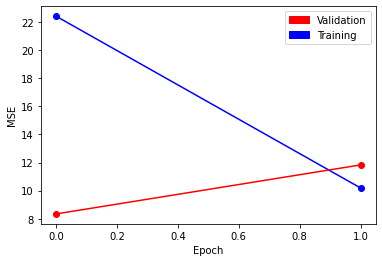

In [43]:
import pandas as pd
import os.path
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#Plotting change in training and val MSE over time
if __name__ == '__main__':

    #Load most recent set of training data
    folder_path = r'D:\Sync\DL_Development\Models'
    file_type = r'\*.csv'
    files = glob.glob(folder_path + file_type)
    training_data = max(files, key=os.path.getctime)
    training_data = pd.read_csv(training_data, sep=",", header=None)
    training_data.columns = ['epoch', 'train_mse', 'val_mse']

    #Plot the change in training and validation mse over time
    fig,ax=plt.subplots()
    ax.plot(training_data["epoch"], training_data["train_mse"],color="blue",marker = "o")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE")
    ax.plot(training_data["epoch"], training_data["val_mse"],color="red",marker="o")
    red_patch = mpatches.Patch(color='red', label='Validation')
    blue_patch = mpatches.Patch(color='blue', label='Training')
    plt.legend(handles=[red_patch, blue_patch])

In [ ]:
#Testing model and plotting results


import os.path
import glob
import torch
from torch_geometric.loader import DataLoader
from pointcloud_dataset_biomass_adapted_V2 import PointCloudsInFiles
from datetime import datetime as dt
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


if __name__ == '__main__':

    # SETUP PARAMETERS
    model_path = rf'D:\Sync\DL_Development\Models\DL_model_{dt.now().strftime("%Y_%m_%d_%H_%M_%S")}.model'
    use_columns = ['intensity_normalized']
    num_points = 10_000
    augment = True
    num_augs = 2
    batch_size = 4
    num_epochs = 2
    writer = SummaryWriter(comment="_10000_points_lr_0.0001_batch_size_1")
    train_dataset_path = r'D:\Sync\Romeo_Data\train'
    val_dataset_path = r'D:\Sync\Romeo_Data\val'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #Load most recent model
    folder_path = r'D:\Sync\DL_Development\Models'
    file_type = r'\*.model'
    files = glob.glob(folder_path + file_type)
    max_file = max(files, key=os.path.getctime)
    model = torch.load(os.path.join(folder_path, max_file))
    print("Using model:", max_file)

    # Get test data
    test_dataset = PointCloudsInFiles(r"D:\Sync\Romeo_Data\test", '*.las', max_points=num_points, use_columns=use_columns,
                                      filter_ground=True, filter_height=1.3)

    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)

    #Load most recent model
    folder_path = r'D:\Sync\DL_Development\Models'
    file_type = r'\*.model'
    files = glob.glob(folder_path + file_type)
    max_file = max(files, key=os.path.getctime)
    model = torch.load(max_file)
    print("Using model:", max_file)

    # Get test data
    test_dataset = PointCloudsInFiles(r"D:\Sync\Romeo_Data\test", '*.las', max_points=num_points, use_columns=use_columns,
                                      filter_ground=True, filter_height=1.3)

    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)

    model.eval()
    for idx, data in enumerate(test_loader):
         data = data.to(device)
    pred = model(data)[:, 0].to('cpu').detach().numpy()
    obs = data.y.to('cpu').detach().numpy()


    #Get residuals
    resid = obs - pred

    #Plot predicted vs. observed values

    #Plot observed vs. predicted
    f, (ax1, ax2) = plt.subplots(2, 1)
    ax1.scatter(obs, pred)
    ax1.set(xlabel='Observed Biomass (Tons)', ylabel='Predicted Biomass (Tons)')

    #Plot residuals
    ax2.scatter(pred, resid)
    ax2.set(xlabel='Predicted Biomass (Tons)', ylabel='Residuals')

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    plt.show()

In [4]:
import optuna
import pandas
from datetime import datetime as dt
n_trials = 5

def objective(trial):
    x = trial.suggest_float("x", -1, 1)
    return x ** 2


study = optuna.create_study()
study.optimize(objective, n_trials=n_trials)

# Create a dataframe from the study.
df = study.trials_dataframe()
assert isinstance(df, pandas.DataFrame)
print(df)
t_now = dt.now().strftime("%Y_%m_%d_%H_%M_%S")
df.to_excel(rf"D:\Sync\DL_Development\Hyperparameter_Tuning\Hyperparameter_tuning_results_{t_now}_.xlsx")

[I 2022-06-22 16:44:33,610] A new study created in memory with name: no-name-f3feb08f-5547-4bb1-80f1-e9d6de54abe5
[I 2022-06-22 16:44:33,622] Trial 0 finished with value: 0.6551098547563775 and parameters: {'x': 0.8093885684616366}. Best is trial 0 with value: 0.6551098547563775.
[I 2022-06-22 16:44:33,622] Trial 1 finished with value: 0.4967576647545796 and parameters: {'x': -0.704810375033299}. Best is trial 1 with value: 0.4967576647545796.
[I 2022-06-22 16:44:33,630] Trial 2 finished with value: 0.00036156409763089863 and parameters: {'x': 0.019014838879961582}. Best is trial 2 with value: 0.00036156409763089863.
[I 2022-06-22 16:44:33,632] Trial 3 finished with value: 0.02630013999840691 and parameters: {'x': -0.16217317903527362}. Best is trial 2 with value: 0.00036156409763089863.
[I 2022-06-22 16:44:33,632] Trial 4 finished with value: 0.004564450684703719 and parameters: {'x': 0.06756071850345968}. Best is trial 2 with value: 0.00036156409763089863.


   number     value             datetime_start          datetime_complete  \
0       0  0.655110 2022-06-22 16:44:33.621464 2022-06-22 16:44:33.622627   
1       1  0.496758 2022-06-22 16:44:33.622627 2022-06-22 16:44:33.622627   
2       2  0.000362 2022-06-22 16:44:33.622627 2022-06-22 16:44:33.622627   
3       3  0.026300 2022-06-22 16:44:33.630675 2022-06-22 16:44:33.632709   
4       4  0.004564 2022-06-22 16:44:33.632709 2022-06-22 16:44:33.632709   

                duration  params_x     state  
0 0 days 00:00:00.001163  0.809389  COMPLETE  
1        0 days 00:00:00 -0.704810  COMPLETE  
2        0 days 00:00:00  0.019015  COMPLETE  
3 0 days 00:00:00.002034 -0.162173  COMPLETE  
4        0 days 00:00:00  0.067561  COMPLETE  
